In [1]:
!pip install -U jaxlib[cuda112]==0.3.15 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -U jax[cuda112]==0.3.17 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install optax
!pip install dm-haiku
!pip install tensorflow-probability==0.17
!pip install git+https://github.com/blackjax-devs/blackjax.git
!apt update
!apt install -y graphviz
!apt-get -y install swig
!pip install smac
!pip install graphviz
!pip install gplearn

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 MB 12.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.3.8+cuda11.cudnn82
    Uninstalling jaxlib-0.3.8+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.3.8+cuda11.cudnn82
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for jax: filename=jax-0.3.17-py3-none-any.whl size=1217849 sha256=da767a95a5655593d68fbb139ae97c44651becfd3bb832dd6baafc92db68da9c
  Stored in directory: /root/.cache/pip/wheels/36/cd/88/2d90379f7549c27d5654e893f74210f30f0c645c23a71e6f56
Successfully built jax
  Attempting uninstall: jax
    Found existing installation: jax 0.3.14
    Uninstalling jax-0.3.14:
      Successfully uninstalled jax-0.3.14
  

In [2]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "False"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
os.environ["JAX_ENABLE_X64"] = "True"

SERVER = 1

if not SERVER:
    %cd /home/xabush/code/snet/moses-incons-pen-xp/notebooks/variable_selection/cancer/nn
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax as tfp
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
tfd = tfp.distributions
import jax
import jax.numpy as jnp
import haiku as hk
import numpy as np
import optax
from nn_util import *
plt.style.use('ggplot')
%load_ext autoreload

In [3]:
if SERVER:
    data_dir = "."
else:
    data_dir = "/home/xabush/code/snet/moses-incons-pen-xp/data"

### GDSC Cell Line

#### Tamoxifen

In [4]:
gdsc_dir = f"{data_dir}/cell_line/gdsc2"
gdsc_exp_tamox_data = pd.read_csv(f"{gdsc_dir}/tamoxifen_response_gene_expr.csv")
gdsc_exp_tamox_data.shape

(406, 37265)

In [5]:
X, target = gdsc_exp_tamox_data.iloc[:,:-1], gdsc_exp_tamox_data.iloc[:,-1]
# change to -log10(IC_50) to make it comparable
target = -np.log10(np.exp(target)) # exp b/c the values are natural logs of raw IC_50

In [6]:
cancer_driver_genes_df = pd.read_csv(f"{data_dir}/cell_line/driver_genes_20221018.csv")
cancer_driver_genes_df

,symbol,method_of_action,cosmic_moa,intogen_moa,gene_id
0,ABCB1,Act,NaN,Act,SIDG00064
1,ABI1,ambiguous,"TSG, fusion",ambiguous,SIDG00145
2,ABL1,Act,"oncogene, fusion",Act,SIDG00150
3,ABL2,Act,"oncogene, fusion",Act,SIDG00151
4,ACKR3,Act,"oncogene, fusion",Act,SIDG00205
...,...,...,...,...,...
778,ZNF814,Act,NaN,Act,SIDG42334
779,ZNF93,LoF,NaN,LoF,SIDG41755
780,ZNRF3,LoF,NaN,LoF,SIDG42403
781,ZRSR2,LoF,TSG,LoF,SIDG42422


In [7]:
cols = X.columns.to_list()
driver_syms = cancer_driver_genes_df["symbol"].to_list()
sym_list = [sym.strip() for sym in cols if sym in driver_syms]

In [8]:
X_selected = X[sym_list]
X_selected.shape

(406, 768)

In [9]:
seed = 261
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_selected, target, random_state=seed, shuffle=True, test_size=0.2)
X_train_df, X_val_df, y_train_df, y_val_df = train_test_split(X_train_df, y_train_df, shuffle=True,
                                                              random_state=seed, test_size=0.2)

In [10]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler, Normalizer, StandardScaler

train_transformer = QuantileTransformer(random_state=seed, output_distribution="normal").fit(X_train_df)
# train_transformer = PowerTransformer().fit(X_train_df)
train_transformed = train_transformer.transform(X_train_df)
val_transformed = train_transformer.transform(X_val_df)
test_transformed = train_transformer.transform(X_test_df)

X_train_df = pd.DataFrame(train_transformed, columns=X_train_df.columns)
X_val_df = pd.DataFrame(val_transformed, columns=X_val_df.columns)
X_test_df = pd.DataFrame(test_transformed, columns=X_test_df.columns)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (259). n_quantiles is set to n_samples.
  warnings.warn(


In [11]:
X_train, y_train = X_train_df.values, y_train_df.values
X_val, y_val = X_val_df.values, y_val_df.values
X_test, y_test = X_test_df.values, y_test_df.values

In [12]:
class TrainingState(NamedTuple):
    params: hk.Params
    avg_params: hk.Params
    opt_state: optax.OptState
    net_state: hk.State

In [424]:
class Conv1DNet:
    def __init__(self, optim, hidden_size=4096, cha_input=16, cha_hidden=32,
                 K=2, dropout_input=0.1, dropout_hidden=0.2, dropout_output=0.2, l2_coef=1e-5, act_fn=jax.nn.relu):

        self.act_fn = act_fn
        self.optimiser = optim
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

        # hidden_size = sign_size*cha_input
        # hidden_size = sign_size
        # sign_size1 = sign_size
        # sign_size2 = sign_size//2
        # output_size = (sign_size//4) * cha_hidden

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_input_reshape = int(hidden_size/cha_input)
        self.cha_hidden = cha_hidden
        # self.K = K
        # self.sign_size1 = sign_size1
        # self.sign_size2 = sign_size2
        # self.output_size = output_size
        self.dropout_input = dropout_input
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output
        self.l2_coef = l2_coef

        self.batch_norm1 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.dense1 = lambda x: hk.Linear(hidden_size, with_bias=False)(x)

        # 1st conv layer
        self.batch_norm_c1 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.conv1 = lambda x: hk.Conv1D(
            cha_input,
            kernel_shape=5,
            stride = 1,
            padding = "VALID",
            # feature_group_count=cha_input,
            with_bias=False)(x)

        self.ave_po_c1 = lambda x: hk.AvgPool(window_shape=4, strides=1, padding="VALID")(x)

        #2nd conv layer
        self.batch_norm_c2 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.conv2 = lambda x: hk.Conv1D(
            cha_hidden,
            kernel_shape = 3,
            stride = 1,
            with_bias=False)(x)

        # 3rd conv layer
        self.batch_norm_c3 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.conv3 = lambda x: hk.Conv1D(
            cha_hidden,
            kernel_shape = 3,
            stride = 1,
            with_bias = False)(x)

        # 4th conv layer
        self.batch_norm_c4 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.conv4 = lambda x: hk.Conv1D(
            cha_hidden,
            kernel_shape=5,
            stride=1,
            # feature_group_count=cha_hidden,
            with_bias=False)(x)

        self.avg_po_c4 = lambda x: hk.AvgPool(window_shape=4, strides=2, padding="VALID")(x)

        self.flt = lambda x: hk.Flatten()(x)
        self.batch_norm2 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.dense2 = lambda x: hk.Linear(1, with_bias=False)(x)

        self._forward = hk.transform_with_state(self._forward_fn)
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

    def dropout(self, rng, rate, x, is_training):
        if is_training:
            return hk.dropout(rng, rate, x)

        return x

    def _forward_fn(self, x, is_training):
        key = hk.next_rng_key()
        keys = jax.random.split(key, 5)

        # x = self.batch_norm1(x, is_training)
        x = self.dropout(keys[0], self.dropout_input, x, is_training)
        x = self.dense1(x)
        x = jax.nn.celu(x)

        x = x.reshape(x.shape[0], self.cha_input, self.cha_input_reshape)

        x = self.batch_norm_c1(x, is_training)
        x = self.conv1(x)
        x = self.act_fn(x)

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x, is_training)
        x = self.dropout(keys[1], self.dropout_hidden, x, is_training)
        x = self.conv2(x)
        x = self.act_fn(x)
        x_s = x

        x = self.batch_norm_c3(x, is_training)
        x = self.dropout(keys[2], self.dropout_hidden, x, is_training)
        x = self.conv3(x)
        x = self.act_fn(x)

        x = self.batch_norm_c4(x, is_training)
        x = self.conv4(x)
        x = x + x_s # skip connection
        x = self.act_fn(x)

        x = self.avg_po_c4(x)

        x = self.flt(x)

        x = self.batch_norm2(x, is_training)
        x = self.dropout(keys[4], self.dropout_output, x, is_training)
        x = self.dense2(x)

        return x



    def init(self, rng, x):
        params, net_state = self._forward.init(rng, x, is_training=True)
        opt_state = self.optimiser.init(params)
        return TrainingState(params, params, opt_state, net_state)

    def apply(self, params, net_state, x, key, is_training=True):
        return self._forward.apply(params, net_state, key, x, is_training)


    def update(self, key, train_state, x, y):
        params, avg_params, opt_state, net_state = train_state
        grads, net_state = jax.grad(self.loss, has_aux=True)(params, net_state, key, x, y)
        updates, opt_state = self.optimiser.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        avg_params = optax.incremental_update(params, avg_params, step_size=0.8)
        return TrainingState(params, avg_params, opt_state, net_state)



    def loss(self, params, net_state, key, x, y):
        preds_mean, state = self.apply(params, net_state, x, key, is_training=True)
        # preds_mean, preds_std = jnp.split(preds, [1], axis=-1)
        # preds_std = jax.nn.softplus(preds_std)
        preds_mean = preds_mean.squeeze()
        l2_loss = jnp.mean(optax.l2_loss(y, preds_mean)) / x.shape[0]
        l2_reg = 0.5 * sum(
                jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))

        return l2_loss + self.l2_coef*l2_reg, state


In [339]:
from sklearn.metrics import r2_score
import torch
torch.backends.cudnn.deterministic = True
from tqdm import tqdm

def train_nn_model(rng_key, train_loader, val_data, epochs, lr_0, max_lr, l2_coef,
                   dropout_input=0.1, dropout_hidden=0.1, dropout_output=0.1,
                   act_fn=jax.nn.relu, patience=20):



    num_batches = len(train_loader)
    total_steps = num_batches*epochs

    print(f"Num batches: {num_batches}, Total steps: {total_steps}")

    # step_size_fn = lambda count: lr_0

    step_size_fn = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=max_lr, div_factor=1e3, pct_start=0.1)
    optim = optax.chain(optax.scale_by_schedule(step_size_fn), optax.adam(lr_0))

    model = Conv1DNet(optim, dropout_input=dropout_input, dropout_hidden=dropout_hidden, dropout_output=dropout_output, act_fn=act_fn, l2_coef=l2_coef)

    train_state = model.init(rng_key ,next(iter(train_loader))[0])
    # states = []
    val_losses = []
    step = 0
    key = rng_key
    early_stopping = 0
    for epoch in tqdm(range(epochs)):
        for batch_x, batch_y in train_loader:
            _, key = jax.random.split(key, 2)
            train_state = model.update(key, train_state, batch_x, batch_y)
            # states.append(train_state)
            step += 1
        val_loss  = eval_nn_model(key, model, val_data.data, val_data.target, train_state)
        if epoch != 0 and (val_loss > val_losses[-1]):
            early_stopping += 1
            if early_stopping > patience:
                print(f"Early stopping at epoch: {epoch}, Total train steps: {step}")
                break
        else:
            early_stopping = 0

        val_losses.append(val_loss)

    print(f"Total number of steps trained: {step}")
    return model, train_state, val_losses

def eval_nn_model(rng_key, model, X, y, state):
    preds_mean, _ = model.apply(state.avg_params, state.net_state, X, rng_key, is_training=False)
    preds_mean = preds_mean.squeeze()
    # print(preds_mean)

    rmse = jnp.sqrt(jnp.mean((y - preds_mean)**2))

    return rmse

def score_nn_model(rng_key, model, X, y, state):
    preds_mean, _ = model.apply(state.avg_params, state.net_state, X, rng_key, is_training=False)
    preds_mean = preds_mean.squeeze()
    # print(preds_mean)

    rmse = jnp.sqrt(jnp.mean((y - preds_mean)**2))
    r2 = r2_score(y, preds_mean)

    return rmse, r2

In [492]:
from smac.facade.smac_hpo_facade import SMAC4HPO
from smac.scenario.scenario import Scenario
from smac.configspace import ConfigurationSpace
from ConfigSpace.hyperparameters import (
    CategoricalHyperparameter,
    UniformFloatHyperparameter,
    UniformIntegerHyperparameter,
)

from ConfigSpace import InCondition, Configuration

import math

def get_configspace_bnn_bg()-> ConfigurationSpace:

    # Build Configuration Space which defines all parameters and their ranges.
    cs  = ConfigurationSpace()
    lr = CategoricalHyperparameter("lr", [1e-4, 1e-3, 1e-2], default_value=1e-3)
    disc_lr = CategoricalHyperparameter("disc_lr", [0.1, 0.3, 0.5, 0.6, 0.8, 0.9], default_value=0.5)
    max_lr = UniformFloatHyperparameter("max_lr", 0.1, 2.0)
    batch_size = CategoricalHyperparameter("batch_size", [32, 64, 80], default_value=32)

    eta = UniformFloatHyperparameter("eta", 1.0, 10)
    mu = UniformFloatHyperparameter("mu", 1e-5, 1.0)

    dropout_hidden = CategoricalHyperparameter("dropout_hidden", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], default_value=0.2)
    dropout_output = CategoricalHyperparameter("dropout_output", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], default_value=0.2)

    l2_coef = UniformFloatHyperparameter("l2_coef", 1e-10, 1e-4)

    cs.add_hyperparameters([lr, disc_lr, max_lr, batch_size, eta, mu, dropout_hidden, dropout_output, l2_coef])

    return cs

def get_configspace_nn()-> ConfigurationSpace:

    # Build Configuration Space which defines all parameters and their ranges.
    cs  = ConfigurationSpace()
    lr = CategoricalHyperparameter("lr", [1e-4, 1e-3, 1e-2], default_value=1e-3)
    max_lr = UniformFloatHyperparameter("max_lr", 0.1, 2.0)
    batch_size = CategoricalHyperparameter("batch_size", [32, 64, 80], default_value=32)

    dropout_input = CategoricalHyperparameter("dropout_input", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], default_value=0.2)
    dropout_hidden = CategoricalHyperparameter("dropout_hidden", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], default_value=0.2)
    dropout_output = CategoricalHyperparameter("dropout_output", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5], default_value=0.2)

    l2_coef = UniformFloatHyperparameter("l2_coef", 1e-10, 1e-4)

    cs.add_hyperparameters([lr, max_lr, batch_size, dropout_input, dropout_hidden, dropout_output, l2_coef])

    return cs

def generate_train_nn_cs(seed, X_train, X_val, y_train, y_val):
    rng_key = jax.random.PRNGKey(seed)
    def train_cs(config: Configuration)-> float:
        epochs = 1000
        batch_size = config["batch_size"]
        max_lr = config["max_lr"]
        lr_0 = config["lr"]

        dropout_input = config["dropout_input"]
        dropout_hidden = config["dropout_hidden"]
        dropout_output = config["dropout_output"]

        l2_coef = config["l2_coef"]

        torch.manual_seed(seed)
        data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
        val_data = NumpyData(X_val, y_val)
        nn_model, state, _ = train_nn_model(rng_key, data_loader, val_data, epochs, lr_0, max_lr, l2_coef,
                                                     dropout_input=dropout_input, dropout_hidden=dropout_hidden, dropout_output=dropout_output,
                                                     act_fn=jax.nn.swish, patience=10)


        val_loss  = eval_nn_model(rng_key, nn_model, val_data.data, val_data.target, state)
        if math.isnan(val_loss):
            return 1e9

        return val_loss


    return train_cs

def generate_train_bg_nn_cs(seed, X_train, X_val, y_train, y_val, J):
    rng_key = jax.random.PRNGKey(seed)
    def train_cs(config: Configuration)-> float:
        epochs = 1000
        batch_size = config["batch_size"]
        max_lr = config["max_lr"]
        lr_0 = config["lr"]

        disc_lr_0 = config["disc_lr"]
        eta = config["eta"]
        mu = config["mu"]

        dropout_hidden = config["dropout_hidden"]
        dropout_output = config["dropout_output"]

        l2_coef = config["l2_coef"]

        torch.manual_seed(seed)
        data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
        val_data = NumpyData(X_val, y_val)
        nn_model, state, _ = train_bg_nn_model(rng_key, data_loader, val_data, epochs, lr_0, disc_lr_0, max_lr, l2_coef,
                                            J, eta, mu, dropout_hidden=dropout_hidden, dropout_output=dropout_output,
                                            act_fn=jax.nn.swish, patience=10)


        val_loss  = eval_bg_nn_model(rng_key, nn_model, val_data.data, val_data.target, state)
        if math.isnan(val_loss):
            return 1e9

        return val_loss


    return train_cs

def optimize_hyper_parameters(seed, X_train, X_val, y_train, y_val, total_time=60, bg=False, J=None):

    if bg:
        cs = get_configspace_bnn_bg()
        train_cs = generate_train_bg_nn_cs(seed, X_train, X_val, y_train, y_val, J)
    else:
        cs = get_configspace_nn()
        train_cs = generate_train_nn_cs(seed, X_train, X_val, y_train, y_val)

    scenario = Scenario({
        "run_obj": "quality",
        "wallclock-limit": total_time,
        "cs": cs,
        "deterministic": True,
        "cutoff": 10,  # runtime limit for the target algorithm
        "seed": seed
    })

    smac = SMAC4HPO(scenario=scenario, rng=np.random.RandomState(seed), tae_runner=train_cs)

    tae = smac.get_tae_runner()

    try:
        incumbent = smac.optimize()

    finally:
        incumbent = smac.solver.incumbent


    inc_val = tae.run(config=incumbent, seed=seed)

    return incumbent, inc_val[1]

In [458]:
# config, score = optimize_hyper_parameters(seed, X_train, X_val, y_train, y_val, total_time=300)
print(config)
print(score)

Configuration(values={
  'batch_size': 32,
  'dropout_hidden': 0.5,
  'dropout_input': 0.2,
  'dropout_output': 0.1,
  'l2_coef': 4.928562866785006e-06,
  'lr': 0.001,
  'max_lr': 1.0662692129611968,
})

0.5059036754755423


In [148]:
import warnings

warnings.filterwarnings("ignore")
rng_key = jax.random.PRNGKey(seed)
epochs = 1000
batch_size = config["batch_size"]
lr_0, max_lr = config["lr"], config["max_lr"]
hidden_size = 4096

torch.manual_seed(seed)
data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
val_data = NumpyData(X_val, y_val)

nn_model, state, val_losses = train_nn_model(rng_key, data_loader, val_data, epochs, lr_0, max_lr,
                                             dropout_input=config["dropout_input"], dropout_hidden=config["dropout_hidden"],
                                             dropout_output=config["dropout_output"], l2_coef=config["l2_coef"],
                                             act_fn=jax.nn.swish, patience=10)

Num batches: 8, Total steps: 8000


 41%|████▏     | 414/1000 [00:45<01:04,  9.02it/s]

Early stopping at epoch: 414, Total train steps: 3320
Total number of steps trained: 3320


In [149]:
rmse_val, r2_val = score_nn_model(rng_key, nn_model, X_val, y_val, state)
rmse_test, r2_test = score_nn_model(rng_key, nn_model, X_test, y_test, state)
print(f"Val RMSE: {rmse_val}, r2_score: {r2_val}")
print(f"Test RMSE: {rmse_test}, r2_score: {r2_test}")

Val RMSE: 0.5059036754755423, r2_score: 0.1048661095859238
Test RMSE: 0.4792797933885309, r2_score: 0.19038852881809532


In [82]:
J = np.load(f"{data_dir}/cell_line/cancer_genes_net.npy")
np.count_nonzero(J)

11862

In [261]:
from optim_util import *
class BgTrainingState(NamedTuple):
    params: hk.Params
    avg_params: hk.Params
    opt_state: optax.OptState
    net_state: hk.State
    disc_state: Pytree
    avg_disc_state: Pytree
    disc_opt_state: OptaxSGLDState

In [443]:
class BGConv1DNet:
    def __init__(self, optim, disc_optim, J, eta, mu, hidden_size=4096, cha_input=16, cha_hidden=32,
                 dropout_hidden=0.2, dropout_output=0.2, l2_coef=1e-5, act_fn=jax.nn.relu):

        self.act_fn = act_fn
        self.optimiser = optim
        self.disc_optimiser = disc_optim
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

        self.J = J
        self.eta = eta
        self.mu = mu

        self.hidden_size = hidden_size
        self.cha_input = cha_input
        self.cha_input_reshape = int(hidden_size/cha_input)
        self.cha_hidden = cha_hidden
        self.dropout_hidden = dropout_hidden
        self.dropout_output = dropout_output
        self.l2_coef = l2_coef

        self.batch_norm1 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.dense1 = lambda x: hk.Linear(hidden_size, with_bias=False)(x)

        # 1st conv layer
        self.batch_norm_c1 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.conv1 = lambda x: hk.Conv1D(
            cha_input,
            kernel_shape=5,
            stride = 1,
            padding = "VALID",
            # feature_group_count=cha_input,
            with_bias=False)(x)

        self.ave_po_c1 = lambda x: hk.AvgPool(window_shape=4, strides=1, padding="VALID")(x)

        #2nd conv layer
        self.batch_norm_c2 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.conv2 = lambda x: hk.Conv1D(
            cha_hidden,
            kernel_shape = 3,
            stride = 1,
            with_bias=False)(x)

        # 3rd conv layer
        self.batch_norm_c3 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.conv3 = lambda x: hk.Conv1D(
            cha_hidden,
            kernel_shape = 3,
            stride = 1,
            with_bias = False)(x)

        # 4th conv layer
        self.batch_norm_c4 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.conv4 = lambda x: hk.Conv1D(
            cha_hidden,
            kernel_shape=5,
            stride=1,
            # feature_group_count=cha_hidden,
            with_bias=False)(x)

        self.avg_po_c4 = lambda x: hk.AvgPool(window_shape=4, strides=2, padding="VALID")(x)

        self.flt = lambda x: hk.Flatten()(x)
        self.batch_norm2 = lambda x, is_training: hk.BatchNorm(True, True, 0.999)(x, is_training)
        self.dense2 = lambda x: hk.Linear(1, with_bias=False)(x)

        self._forward = hk.transform_with_state(self._forward_fn)
        self.loss = jax.jit(self.loss)
        self.update = jax.jit(self.update)

    def dropout(self, rng, rate, x, is_training):
        if is_training:
            return hk.dropout(rng, rate, x)

        return x

    def _forward_fn(self, x, gamma, is_training):

        if is_training:
            x = x @ jnp.diag(gamma)
        key = hk.next_rng_key()
        keys = jax.random.split(key, 3)

        # x = self.batch_norm1(x, is_training)
        x = self.dense1(x)
        # x = jax.nn.celu(x)
        x = self.act_fn(x)

        x = x.reshape(x.shape[0], self.cha_input, self.cha_input_reshape)

        x = self.batch_norm_c1(x, is_training)
        x = self.conv1(x)
        x = self.act_fn(x)

        x = self.ave_po_c1(x)

        x = self.batch_norm_c2(x, is_training)
        x = self.dropout(keys[0], self.dropout_hidden, x, is_training)
        x = self.conv2(x)
        x = self.act_fn(x)
        x_s = x

        x = self.batch_norm_c3(x, is_training)
        x = self.dropout(keys[1], self.dropout_hidden, x, is_training)
        x = self.conv3(x)
        x = self.act_fn(x)

        x = self.batch_norm_c4(x, is_training)
        x = self.conv4(x)
        x = x + x_s # skip connection
        x = self.act_fn(x)

        x = self.avg_po_c4(x)

        x = self.flt(x)

        x = self.batch_norm2(x, is_training)
        x = self.dropout(keys[2], self.dropout_output, x, is_training)
        x = self.dense2(x)

        return x



    def init(self, rng, x):
        gamma = tfd.Bernoulli(0.5*jnp.ones(x.shape[-1])).sample(seed=rng)*1.
        params, net_state = self._forward.init(rng, x, gamma, is_training=True)
        opt_state = self.optimiser.init(params)
        disc_opt_state = self.disc_optimiser.init(gamma)
        return BgTrainingState(params, params, opt_state, net_state, gamma, gamma, disc_opt_state)

    def apply(self, params, net_state, key, gamma, x, is_training):
        return self._forward.apply(params, net_state, key, x, gamma, is_training)

    def update(self, key, train_state, x, y):
        params, avg_params, opt_state, net_state, gamma, avg_gamma, disc_opt_state = train_state
        grads, net_state = jax.grad(self.loss, has_aux=True)(params, net_state, key, gamma, x, y)
        updates, opt_state = self.optimiser.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        avg_params = optax.incremental_update(params, avg_params, step_size=0.001)

        disc_grads, net_state = jax.grad(self.disc_loss, has_aux=True)(gamma, params, net_state, key, x, y)
        gamma, disc_opt_state = self.disc_optimiser.update(key, gamma, disc_grads, disc_opt_state)
        avg_gamma = optax.incremental_update(gamma, avg_gamma, step_size=0.01)
        return BgTrainingState(params, avg_params, opt_state, net_state, gamma, avg_gamma, disc_opt_state)

    def loss(self, params, net_state, key, gamma, x, y):
        preds_mean, state = self.apply(params, net_state, key, gamma, x, is_training=True)
        preds_mean = preds_mean.squeeze()
        l2_loss = jnp.mean(optax.l2_loss(y, preds_mean)) / x.shape[0]
        l2_reg = 0.5 * sum(
            jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))

        return l2_loss + self.l2_coef*l2_reg, state

    def disc_loss(self, gamma, params, net_state, key, x, y):

        net_loss, state = self.loss(params, net_state, key, gamma, x, y)
        log_prior = self.ising_prior(gamma)

        return log_prior - net_loss, state

    # def ising_prior(self, gamma):
    #     """Log probability of the Ising model - prior over the discrete variables"""
    #     return self.eta*(gamma.T @ self.J @ gamma) + self.mu*jnp.sum(gamma)

    def ising_prior(self, gamma):
        x = (2 * gamma) - 1

        xg = x @ self.J
        xgx = (xg * x).sum(-1)
        return self.eta*xgx - self.mu*jnp.sum(x)

In [450]:
from sklearn.metrics import r2_score
import torch
torch.backends.cudnn.deterministic = True
from tqdm import tqdm

def train_bg_nn_model(rng_key, train_loader, val_data, epochs, lr_0, disc_lr_0, max_lr, l2_coef,
                   J, eta, mu, dropout_hidden=0.1, dropout_output=0.1,
                   act_fn=jax.nn.relu, patience=10):



    num_batches = len(train_loader)
    total_steps = num_batches*epochs

    print(f"Num batches: {num_batches}, Total steps: {total_steps}")

    disc_step_size_fn = lambda count: disc_lr_0
    disc_optim = disc_sgld_gradient_update(disc_step_size_fn, momentum_decay=0, preconditioner=get_identity_preconditioner())

    step_size_fn = optax.linear_onecycle_schedule(transition_steps=total_steps, peak_value=max_lr, div_factor=1e3, pct_start=0.1)
    optim = optax.chain(optax.scale_by_schedule(step_size_fn), optax.adam(lr_0))

    model = BGConv1DNet(optim, disc_optim, J, eta, mu, dropout_hidden=dropout_hidden, dropout_output=dropout_output, act_fn=act_fn, l2_coef=l2_coef)

    train_state = model.init(rng_key ,next(iter(train_loader))[0])
    # disc_states = []
    val_losses = []
    step = 0
    key = rng_key
    early_stopping = 0
    for epoch in tqdm(range(epochs)):
        for batch_x, batch_y in train_loader:
            _, key = jax.random.split(key, 2)
            train_state = model.update(key, train_state, batch_x, batch_y)
            # disc_states.append(train_state.disc_state)
            step += 1
        val_loss  = eval_bg_nn_model(key, model, val_data.data, val_data.target, train_state)
        if epoch != 0 and (val_loss > val_losses[-1]):
            early_stopping += 1
            if early_stopping > patience:
                print(f"Early stopping at epoch: {epoch}, Total train steps: {step}")
                break
        else:
            early_stopping = 0

        val_losses.append(val_loss)

    print(f"Total number of steps trained: {step}")
    return model, train_state, val_losses

def eval_bg_nn_model(rng_key, model, X, y, state):
    # disc_state = jax.random.bernoulli(rng_key, state.avg_disc_state)
    preds_mean, _ = model.apply(state.avg_params, state.net_state, rng_key, state.disc_state, X, is_training=False)
    preds_mean = preds_mean.squeeze()
    # print(preds_mean)

    rmse = jnp.sqrt(jnp.mean((y - preds_mean)**2))

    return rmse

def score_bg_nn_model(rng_key, model, X, y, state):
    # disc_state = jax.random.bernoulli(rng_key, state.avg_disc_state)
    preds_mean, _ = model.apply(state.avg_params, state.net_state, rng_key, state.disc_state, X, is_training=False)
    preds_mean = preds_mean.squeeze()
    # print(preds_mean)

    rmse = jnp.sqrt(jnp.mean((y - preds_mean)**2))
    r2 = r2_score(y, preds_mean)

    return rmse, r2

In [493]:
bg_config, bg_score = optimize_hyper_parameters(seed, X_train, X_val, y_train, y_val, total_time=300, bg=True, J=J)
print(bg_config)
print(bg_score)

Num batches: 3, Total steps: 3000


100%|██████████| 1000/1000 [01:42<00:00,  9.77it/s]


Total number of steps trained: 3000
Num batches: 8, Total steps: 8000


 65%|██████▌   | 653/1000 [01:41<00:53,  6.44it/s]


Early stopping at epoch: 653, Total train steps: 5232
Total number of steps trained: 5232
Num batches: 8, Total steps: 8000


 52%|█████▏    | 522/1000 [01:22<01:15,  6.36it/s]


Early stopping at epoch: 522, Total train steps: 4184
Total number of steps trained: 4184
Num batches: 4, Total steps: 4000


100%|██████████| 1000/1000 [01:53<00:00,  8.78it/s]


Total number of steps trained: 4000
Num batches: 8, Total steps: 8000


 52%|█████▏    | 522/1000 [01:20<01:13,  6.51it/s]

Early stopping at epoch: 522, Total train steps: 4184
Total number of steps trained: 4184
Configuration(values={
  'batch_size': 32,
  'disc_lr': 0.5,
  'dropout_hidden': 0.2,
  'dropout_output': 0.2,
  'eta': 5.5,
  'l2_coef': 5e-05,
  'lr': 0.001,
  'max_lr': 1.05,
  'mu': 0.500005,
})

0.5294856395751633


In [494]:
import warnings

warnings.filterwarnings("ignore")
rng_key = jax.random.PRNGKey(seed)
epochs = 1000
batch_size = bg_config["batch_size"]
disc_lr_0 = bg_config["disc_lr"]
lr_0, max_lr = bg_config["lr"], bg_config["max_lr"]
eta, mu = bg_config["eta"], bg_config["mu"]

torch.manual_seed(seed)
data_loader = NumpyLoader(NumpyData(X_train, y_train), batch_size=batch_size, shuffle=True, drop_last=True)
val_data = NumpyData(X_val, y_val)

bg_nn_model, bg_state, val_losses = train_bg_nn_model(rng_key, data_loader, val_data, epochs, lr_0, disc_lr_0, max_lr,bg_config["l2_coef"],
                                             J, eta, mu, dropout_hidden=bg_config["dropout_hidden"],
                                             dropout_output=bg_config["dropout_output"],
                                             act_fn=jax.nn.swish, patience=10)

Num batches: 8, Total steps: 8000


 52%|█████▏    | 522/1000 [01:21<01:14,  6.41it/s]

Early stopping at epoch: 522, Total train steps: 4184
Total number of steps trained: 4184


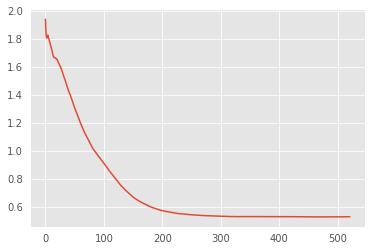

In [495]:
plt.plot(val_losses)

In [496]:
rmse_val, r2_val = score_bg_nn_model(rng_key, bg_nn_model, X_val, y_val, bg_state)
rmse_test, r2_test = score_bg_nn_model(rng_key, bg_nn_model, X_test, y_test, bg_state)
print(f"Val RMSE: {rmse_val}, r2_score: {r2_val}")
print(f"Test RMSE: {rmse_test}, r2_score: {r2_test}")

Val RMSE: 0.5294856395751633, r2_score: 0.01947041337241684
Test RMSE: 0.539304877400437, r2_score: -0.02510206938640458


(array([  2.,  49.,  23.,   8.,   0.,   0.,   0.,   0.,   0., 686.]),
 array([0.1639665 , 0.24756985, 0.3311732 , 0.41477655, 0.4983799 ,
        0.58198325, 0.6655866 , 0.74918995, 0.8327933 , 0.91639665,
        1.        ]),
 <BarContainer object of 10 artists>)

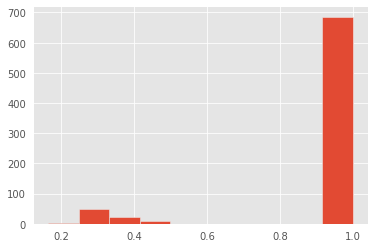

In [497]:
plt.hist(bg_state.avg_disc_state)

In [457]:
np.count_nonzero(bg_state.disc_state)

684

In [440]:
# bnn_feat_idx = np.argsort(bg_state.avg_disc_state)[::-1][:20]
bnn_feat_idx = np.argsort(np.mean(np.array(disc_states), axis=0))[::-1][:20]

In [441]:
bnn_feat_idx

array([448, 589, 736, 180, 337, 306, 508, 181, 476, 243, 640, 587, 458,
       468, 369,  81, 668, 120, 660, 580])

In [421]:
X_train_df.iloc[:,bnn_feat_idx]

,NKX2-1,RPL10,WRN,EHD2,KDR,HTRA2,PLCB4,EIF1AX,PABPC1,FGFR3,SOHLH2,ROS1,NRK,NUP98,LPP,CALR,SYK,CHEK2,STAT5B,RHOH
0,1.990720,-0.495631,0.574113,-1.421957,-5.199338,1.641107,0.409503,0.585607,-0.936847,-0.316085,0.849957,-5.199338,-5.199338,0.409503,0.126641,-0.126641,1.299424,-0.452147,-0.087552,0.346879
1,0.205464,-1.193795,-0.680601,1.118003,0.528865,-1.100033,0.357216,-0.205464,-0.597179,0.205464,0.205464,0.126641,1.213847,0.863984,-0.398960,0.705305,-0.136441,0.430727,-1.346025,-5.199338
2,-5.199338,1.255486,-1.255486,-2.156973,-5.199338,-0.245329,-0.983053,-1.570585,1.118003,-0.175782,-5.199338,-5.199338,-5.199338,0.357216,-1.346025,-0.907124,2.066729,0.185658,0.029151,1.213847
3,-5.199338,1.765264,-0.077803,-0.680601,-5.199338,2.269206,-0.808844,-1.507108,-0.107076,-0.967422,1.118003,-5.199338,-5.199338,-0.346879,-1.720887,0.107076,1.395747,0.644302,1.395747,1.031459
4,2.662687,-1.213847,2.662687,-1.370462,0.398960,0.730448,1.015059,0.705305,-1.065120,-0.597179,-0.388462,-5.199338,-5.199338,-0.265405,-1.370462,-1.155069,0.367591,0.680601,0.068062,0.495631
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,5.199338,-1.449182,0.225352,-1.031459,-5.199338,-1.193795,0.907124,1.346025,-2.420390,-0.195551,0.305888,-5.199338,-5.199338,1.065120,-0.255354,0.517724,1.604849,1.604849,0.849957,0.420092
255,0.484675,0.644302,1.174212,-0.769055,0.255354,-1.322365,1.031459,0.265405,2.156973,0.983053,1.866185,-5.199338,1.234399,-1.924727,-0.863984,0.136441,0.185658,0.998928,-1.048141,0.692900
256,0.822394,1.395747,0.048597,-0.336579,-5.199338,0.245329,-0.009716,-0.068062,-1.604849,0.680601,-0.585607,-5.199338,-5.199338,-1.048141,-0.878182,0.921884,-0.205464,-0.769055,-0.632390,-5.199338
257,0.305888,-0.305888,-1.213847,1.193795,-5.199338,-1.174212,1.604849,-0.398960,-1.449182,0.029151,0.398960,0.822394,5.199338,-0.822394,0.608832,1.136341,-0.097309,-0.585607,-1.924727,-0.585607


In [406]:
from gplearn.genetic import SymbolicTransformer, SymbolicClassifier, SymbolicRegressor
from gplearn.functions import make_function
import operator
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

def get_best_programs(gp, num_models, classifier=True, ascending=True, sort_fit="OOB_fitness"):
    gp_dict = {'Gen': [], "Ind": [], "Fitness": [], 'OOB_fitness': [], "Equation": []}

    if classifier:
        for idGen in range(len(gp._programs)):
            for idPopulation in range(gp.population_size):
                gp_dict["Gen"].append(idGen)
                gp_dict["Ind"].append(idPopulation)
                gp_dict["Fitness"].append(gp._programs[idGen][idPopulation].fitness_)
                gp_dict["OOB_fitness"].append(gp._programs[idGen][idPopulation].oob_fitness_)
                gp_dict["Equation"].append(str(gp._programs[idGen][idPopulation]))
    else:
        for idx, prog in enumerate(gp._programs[-1]):
            gp_dict["Gen"].append(-1)
            gp_dict["Ind"].append(idx)
            gp_dict["Fitness"].append(prog.fitness_)
            gp_dict["OOB_fitness"].append(prog.oob_fitness_)
            gp_dict["Equation"].append(str(prog))

    gp_df = pd.DataFrame(gp_dict).sort_values(sort_fit, ascending=ascending)[:num_models]
    programs = []
    for i in range(num_models):
        gen, ind = int(gp_df.iloc[i]["Gen"]), int(gp_df.iloc[i]["Ind"])
        programs.append(gp._programs[gen][ind])

    return programs, gp_df


def gp_transform(est, X, classifier=False, num_models=100, sort_fit="Fitness"):
    if classifier or (sort_fit == "OOB_fitness"):
        programs, gp_df = get_best_programs(est, num_models, classifier, sort_fit=sort_fit, ascending=classifier)
        out = np.zeros((X.shape[0], len(programs)))
        for i, prog in enumerate(programs):
            out[:, i] = prog.execute(X)

        return out, gp_df
    else:
        return est.transform(X), None

function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                'abs', 'neg', 'inv', 'max', 'min', 'exp']

def train_linear_model(seed, X_train, X_test, y_train, y_test):
    cv = KFold(n_splits=3, random_state=seed, shuffle=True)
    param_grid = {"alpha": np.logspace(-2, 2, 20)}
    grid_cv = GridSearchCV(estimator=Ridge(max_iter=10000), param_grid=param_grid,
                           verbose=0, scoring="r2", cv=cv).fit(X_train, y_train)
    lin_model = Ridge(max_iter=10000, **grid_cv.best_params_)
    lin_model.fit(X_train, y_train)
    y_test_pred = lin_model.predict(X_test)

    test_rmse_score = np.sqrt(np.mean((y_test - y_test_pred)**2))
    test_r2_score = r2_score(y_test, y_test_pred)
    test_pearson, test_pval = stats.pearsonr(y_test, y_test_pred)

    return test_rmse_score, test_r2_score, test_pearson, test_pval

def train_gp(seed, X_train, X_train_2, X_test, y_train, y_train_2, y_test, num_models=5, sort_fit="OOB_fitness", verbose=0, num_gen=100,
             p_cxvr=0.8, p_subt_mut=0.1, p_hmut=0.05, p_pmut=0.1, subsample=0.8, complexity_coef=0.05):
    gp_est = SymbolicTransformer(population_size=1000, hall_of_fame=200, n_components=50, generations=num_gen,
                                 p_crossover=p_cxvr, p_subtree_mutation=p_subt_mut,
                                 p_hoist_mutation=p_hmut, p_point_mutation=p_pmut,
                                 max_samples=subsample, verbose=verbose,
                                 parsimony_coefficient=complexity_coef, random_state=seed)

    gp_est.fit(X_train, y_train)

    gp_features_train, gp_train_df = gp_transform(gp_est, X_train_2, classifier=False, sort_fit=sort_fit, num_models=num_models)
    gp_features_test, gp_test_df = gp_transform(gp_est, X_test, classifier=False, sort_fit=sort_fit, num_models=num_models)

    X_train_comb = np.concatenate([X_train_2, gp_features_train], axis=1)
    X_test_comb = np.concatenate([X_test, gp_features_test], axis=1)


    test_rmse_score, test_r2_score, test_pearson, test_pval = train_linear_model(seed, X_train_comb, X_test_comb, y_train_2, y_test)

    return test_rmse_score, test_r2_score, test_pearson, test_pval, gp_test_df

In [422]:
X_train_2, y_train_2 = jax.random.choice(rng_key, X_train, shape=(X_val.shape[0],), replace=False), jax.random.choice(rng_key, y_train, shape=(X_val.shape[0],), replace=False)
X_gp_train_bnn, X_gp_train_2_bnn, X_gp_val_bnn, X_gp_test_bnn = X_val[:,bnn_feat_idx], X_train_2[:,bnn_feat_idx], X_train[:,bnn_feat_idx], X_test[:,bnn_feat_idx]
y_train_gp, y_train_gp_2, y_val_gp, y_test_gp = y_val, y_train_2, y_train, y_test

In [423]:
bnn_test_rmse_score, bnn_test_r2_score, bnn_test_pcc, bnn_test_pval = train_linear_model(seed, X_gp_train_2_bnn, X_gp_test_bnn, y_train_gp_2, y_test_gp)
print(f"Test rmse: {bnn_test_rmse_score}, r2_score: {bnn_test_r2_score}, pcc: {bnn_test_pcc}, pcc_pval: {bnn_test_pval}")

Test rmse: 0.5148490096871814, r2_score: 0.06576060288625452, pcc: 0.2890981258051059, pcc_pval: 0.008433354355688273


In [409]:
bnn_gp_test_rmse_score, bnn_gp_test_r2_score, bnn_gp_test_pcc, bnn_gp_test_pval, gp_df = train_gp(seed, X_gp_train_bnn, X_gp_train_2_bnn, X_gp_test_bnn,
                                                                                              y_train_gp, y_train_gp_2, y_test_gp, num_models=5, verbose=0, p_cxvr=0.7, p_subt_mut=0.1,
                                                                                              p_hmut=0.1, p_pmut=0.1, complexity_coef=0.01)
print(f"Test rmse: {bnn_gp_test_rmse_score}, r2_score: {bnn_gp_test_r2_score}, pcc: {bnn_gp_test_pcc}, pcc_pval: {bnn_gp_test_pval}")

Test rmse: 0.5439077870952783, r2_score: -0.04267501632493409, pcc: 0.2635821998026937, pcc_pval: 0.01672615922491233


(array([ 83., 180., 240., 104.,  59.,  32.,  26.,  28.,  12.,   4.]),
 array([1.25000e-04, 4.57500e-02, 9.13750e-02, 1.37000e-01, 1.82625e-01,
        2.28250e-01, 2.73875e-01, 3.19500e-01, 3.65125e-01, 4.10750e-01,
        4.56375e-01]),
 <BarContainer object of 10 artists>)

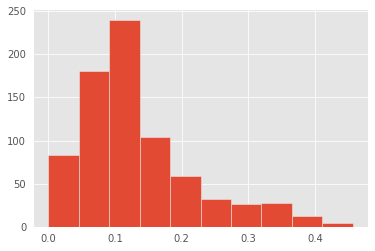

In [410]:
plt.hist(np.mean(np.array(disc_states), axis=0))

In [ ]:
i

(array([6131.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1869.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

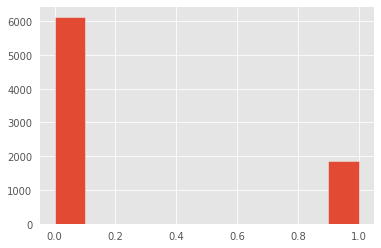

In [442]:
plt.hist(np.array(disc_states)[:,448])